In [361]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

0. Set Hyperparamters

In [359]:
train_ratio = 0.8
validation_ratio = 0.2
epochs = 1000
batch_size = 32
regularization = 0.0001

1. Import Data

In [360]:
def remove_outliers_z_score(df, threshold=2):
    z_scores = (df - df.mean()) / df.std()
    outliers = (z_scores.abs() > threshold).any(axis=1)
    return df[~outliers]

In [362]:
# 1. Import data
NY_data = pd.read_csv("data/NY_data.csv")

# 2. Remove outliers based on z-score
NY_data = remove_outliers_z_score(NY_data)

# 3. Split data into x and y values
y = NY_data['price']
X = NY_data.drop(columns=['price'])

# 4. One Hot Encode Zip Codes
X = pd.get_dummies(X, columns=['zip_code'], dtype=float)

# 5. Split data into Train vs. Test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42)

# 6. Normalize data
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_norm = X_scaler.fit_transform(X_train)
X_val_norm = X_scaler.transform(X_val)
X_test_norm = X_scaler.transform(X_test)

y_train_norm = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_norm = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))

In [363]:
DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(6, input_dim=X.shape[1], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization)),
    tf.keras.layers.Dense(1)
])

early_stop = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

DNN.compile(loss='mse', optimizer='adam')

2. Model Initilization

In [364]:
history = DNN.fit(X_train_norm, y_train_norm, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(X_val_norm, y_val_norm), callbacks=[early_stop])

Epoch 1/1000
944/944 [==============================] - 2s 2ms/step - loss: 0.0560 - val_loss: 0.0404
Epoch 2/1000
944/944 [==============================] - 1s 1ms/step - loss: 0.0343 - val_loss: 0.0309
Epoch 3/1000
944/944 [==============================] - 1s 1ms/step - loss: 0.0263 - val_loss: 0.0218
Epoch 4/1000
944/944 [==============================] - 1s 1ms/step - loss: 0.0200 - val_loss: 0.0177
Epoch 5/1000
944/944 [==============================] - 1s 1ms/step - loss: 0.0148 - val_loss: 0.0121
Epoch 6/1000
944/944 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0086
Epoch 7/1000
944/944 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 8/1000
944/944 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 9/1000
944/944 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 10/1000
944/944 [==============================] - 1s 1ms/step - loss: 0.004

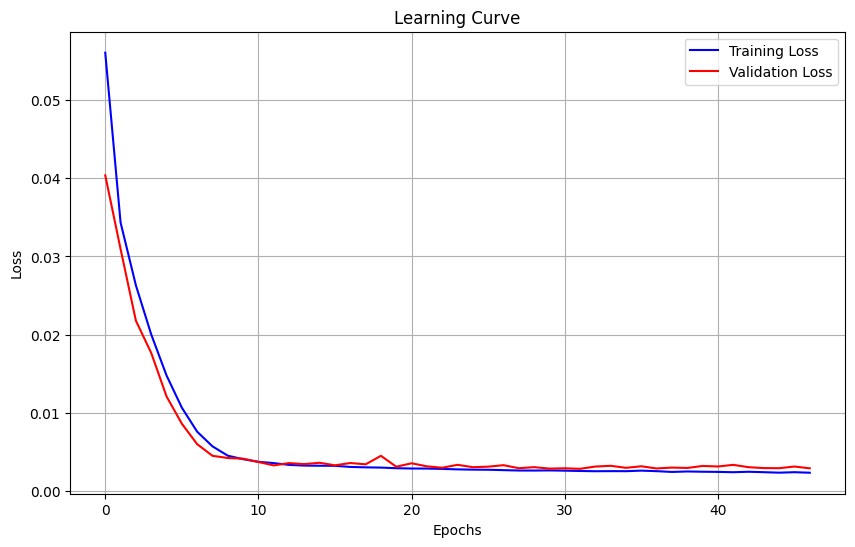

In [365]:
import matplotlib.pyplot as plt

# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [366]:
loss = DNN.evaluate(X_test_norm, y_test_norm)
print("Test Loss:", loss)

295/295 [==============================] - 0s 729us/step - loss: 0.0026
Test Loss: 0.002558457897976041


In [369]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = y_scaler.inverse_transform(DNN.predict(X_test_norm))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

295/295 [==============================] - 0s 651us/step
Mean Absolute Error: 122003.5072231147
Mean Squared Error: 46516566082.38818
Root Mean Squared Error: 215676.9947917213
R-squared: 0.7931052563091857


In [368]:
predictions = DNN.predict(X_test_norm)
predictions = y_scaler.inverse_transform(predictions)


print("Example:")
print("Expected Prices:", ", ".join(str(expected) for expected in y_test.iloc[:5]))
print("Predicted Prices:", " ".join(str(predicted) for predicted in predictions[:5, 0]))

295/295 [==============================] - 0s 638us/step
Example:
Expected Prices: 160000.0, 250000.0, 409000.0, 525000.0, 1948000.0
Predicted Prices: 214732.34 317895.38 465470.6 341265.88 1870496.6
